# MDOF PINN - instance prediction

## Problem overview

The example problem we solve here is the 3DOF nonlinear-stiffness oscillator defined in state space:
$$
\dot{\mathbf{z}} = \mathbf{A}\mathbf{z} + \mathbf{A}_n\mathbf{z}_n + \mathbf{H}\mathbf{f}
$$
where,
$$
\mathbf{z} = \left\{ x_1, x_2, ... , x_n, \dot{x}_1, \dot{x}_2, ... , \dot{x}_n \right\}^T, \quad
\mathbf{f} = \left\{ f_1, f_2, ... , f_n \right\}^T
$$
and $\mathbf{z}_n$ is the nonlinear state vector.
$$
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \quad
\mathbf{A}_n = \begin{bmatrix} 0 \\ -\mathbf{M}^{-1} \mathbf{K}_n \end{bmatrix}, \quad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}
$$
with the initial conditions
$$
\mathbf{x}(0) = \mathbf{x}_0~~,~~\dot{\mathbf{x}}(0) = \dot{\mathbf{x}}_0
$$

As an example, for a 3DOF system with cubic nonlinearities, fixed at the first degree of freedom:
$$
\mathbf{z}_n = g_n(\mathbf{z}) = \left\{ x_1^3, (x_2-x_1)^3, (x_3-x_2)^3 \right\}^T, \quad
\mathbf{K}_n = \begin{bmatrix} k_{n,1} & -k_{n,2} & 0 \\ 0 & k_{n,2} & -k_{n,3} \\ 0 & 0 & k_{n,3} \end{bmatrix}
$$

In [1]:
# add parent directory to path
import sys
sys.path.append('..')

from mdof_pinn import mdof_pinn_stoch, normalise, ParamClipper
import dynasim
from mdof_solutions import gen_ndof_cantilever, add_noise

import numpy as np
import torch

from scipy.stats import qmc

import string
import findiff

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

/Users/marcus/Library/CloudStorage/GoogleDrive-mhaywoodalexander@gmail.com/My Drive/Work/eth/experiments/dynamic-pinns/mdof_instance/../dynasim/base.py:81: UserWarning: No initial conditions provided, proceeding with zero initial state
  warnings.warn('No initial conditions provided, proceeding with zero initial state', UserWarning)


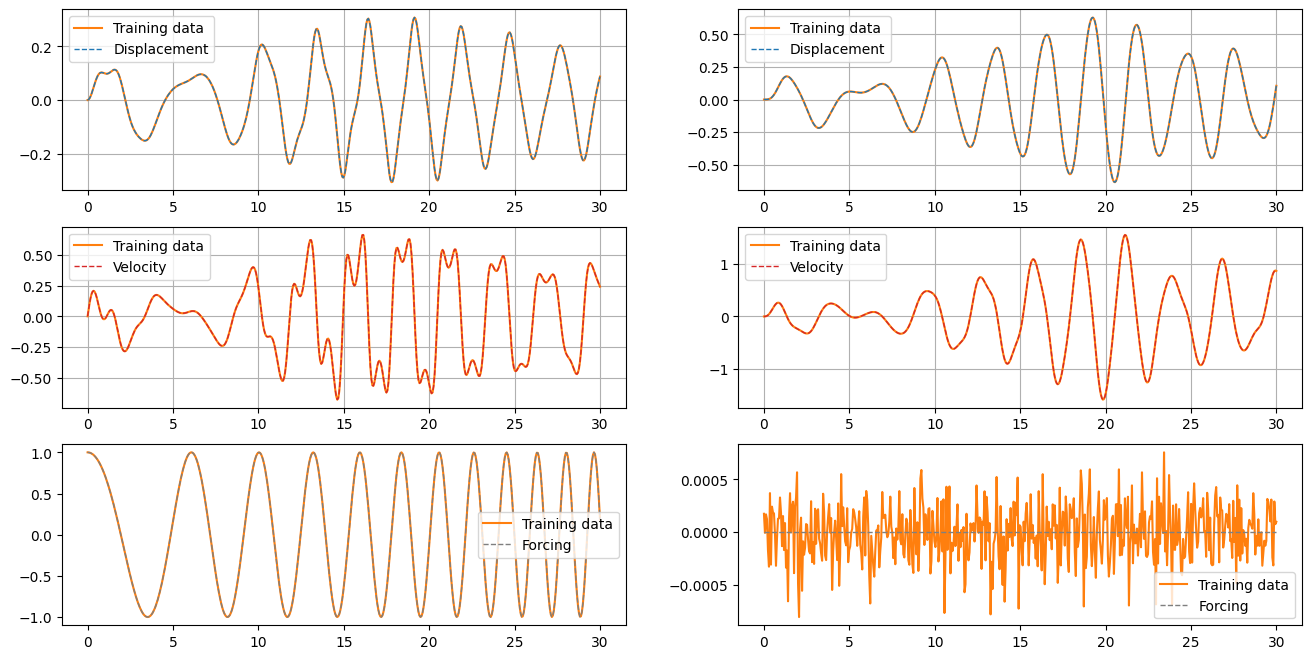

In [2]:
nt = 512
time = np.linspace(0,30,nt)

F0 = 1.0  # N
n_dof = 2

# set physical parameters
k1 = 10.0
c1 = 0.25
m1 = 1.0
kn_ = np.zeros((n_dof))
kn_[0] = 100.0
cn_ = np.zeros((n_dof))

# create nonlinearity
cubic_nonlin = dynasim.nonlinearities.exponent_stiffness(kn_, exponent=3, dofs=n_dof)

# instantiate system
system = dynasim.systems.cantilever(m1, c1, k1, dofs=n_dof, nonlinearity=cubic_nonlin)

true_params = {
    'm_' : system.m_,
    'c_' : system.c_,
    'k_' : system.k_,
    'kn_' : kn_
}

# generate excitations
# system.excitations = [
#     dynasim.actuators.rand_phase_ms(
#         freqs = np.array([0.7, 0.85, 1.6, 1.8]),
#         Sx = np.ones(4)
#     ), None]
system.excitations = [
    dynasim.actuators.sine_sweep(
        w_l = 0.7,
        w_u = 4.0,
        F0 = 1.0
    ), None]

x0 = np.array([-2.0, 0.0, 3.0])
v0 = np.array([-2.0, 0.0, 0.0])
z0 = np.concatenate((x0, v0), axis=0)

data = system.simulate(time, z0=None)

xx, vv = torch.tensor(data['x'], dtype=torch.float32).T, torch.tensor(data['xdot'], dtype=torch.float32).T
F = system.f
xx_noisy, vv_noisy = add_noise(xx, db=-20, seed=43810), add_noise(vv, db=-20, seed=13927)
# aa = torch.zeros_like(xx)
dt = time[1]-time[0]
d_dt = findiff.FinDiff(0,dt)
aa = torch.tensor(d_dt(vv.numpy()))
state_gt = torch.cat((xx,vv),dim=1).T
state_gt_dot = torch.cat((vv,aa),dim=1).T
q_ = (state_gt[:n_dof] - torch.cat((torch.zeros(1,state_gt.shape[1]),state_gt[:n_dof-1])))**3
time = torch.tensor(time).view(-1,1).to(torch.float32)
F = torch.tensor(F.T).to(torch.float32)
F_noisy = add_noise(F, db=-18, seed=1234)

# slice out a number of points
# sampler = qmc.Sobol(d=1, seed=43810)
# sub_ind = np.sort(sampler.integers(l_bounds=nt, n=int(nt/4)), axis=0).squeeze()
sub_ind = np.arange(0, int(nt/1), 1)

t_data = time[sub_ind]
x_data = xx_noisy[sub_ind,:]
v_data = vv_noisy[sub_ind,:]
F_data = F_noisy[sub_ind,:]

if n_dof > 4:
    sub_rows = n_dof // 4 + int((n_dof%4)!=0)
    sub_cols = 4
else:
    sub_rows = 1
    sub_cols = n_dof

fig, axs = plt.subplots(3*sub_rows,sub_cols,figsize=(8*sub_cols,8*sub_rows))
p_count = 0
for j in range(sub_rows):
    for i in range(sub_cols):
        axs[j*3,i].plot(t_data, x_data[:,p_count], color="tab:orange", label="Training data")
        axs[j*3,i].plot(time, xx[:,p_count], color="tab:blue", label="Displacement", linewidth=1.0, linestyle='--')
        axs[j*3,i].grid()
        axs[j*3,i].legend()

        axs[j*3+1,i].plot(t_data, v_data[:,p_count], color="tab:orange", label="Training data")
        axs[j*3+1,i].plot(time, vv[:,p_count], color="tab:red", label="Velocity", linewidth=1.0, linestyle='--')
        # axs[j*3+1,i].set_ylim((-10,10))
        axs[j*3+1,i].grid()
        axs[j*3+1,i].legend()

        axs[j*3+2,i].plot(t_data, F_data[:,p_count], color="tab:orange", label="Training data")
        axs[j*3+2,i].plot(time, F[:,p_count], color="tab:gray", label="Forcing", linewidth=1.0, linestyle='--')
        # axs[j*3+2,i].plot(time, aa[:,p_count], color="tab:gray", label="Acceleration")
        axs[j*3+2,i].legend()
        
        p_count += 1

        if p_count == n_dof:
            break

Normalise and create some plotting functions

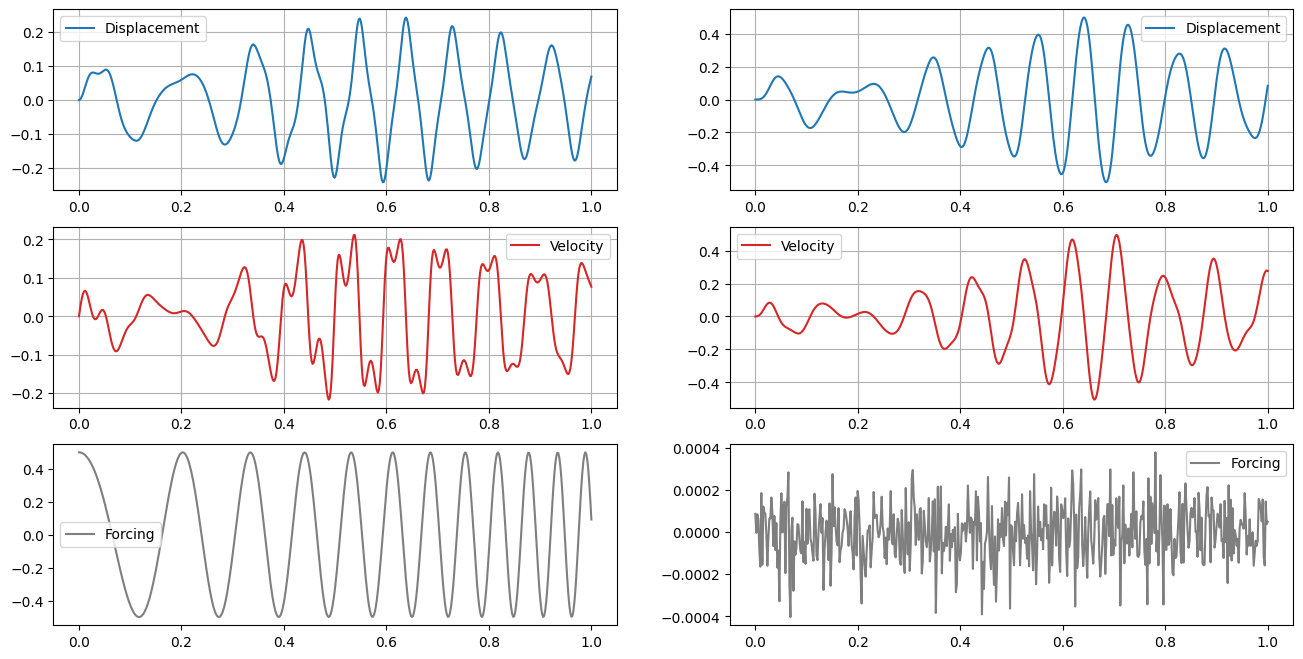

In [3]:
t_hat, alpha_t = normalise(time, "range")
x_hat_gt, alpha_x = normalise(xx_noisy, "range", "all")
v_hat_gt, alpha_v = normalise(vv_noisy, "range", "all")
F_hat_gt, alpha_F = normalise(F_noisy, "range", "all")

t_data = t_hat[sub_ind]
x_data = x_hat_gt[sub_ind,:]
v_data = v_hat_gt[sub_ind,:]
F_data = F_hat_gt[sub_ind,:]

T_hat = t_data[1].item()-t_data[0].item()

fig, axs = plt.subplots(3*sub_rows,sub_cols,figsize=(8*sub_cols,8*sub_rows))
p_count = 0
for j in range(sub_rows):
    for i in range(sub_cols):
        axs[j*3,i].plot(t_hat, x_hat_gt[:,i], color="tab:blue", label="Displacement")
        # axs[j*3,i].scatter(t_data, x_data[:,i], color="tab:orange", label="Training data")
        axs[j*3,i].grid()
        axs[j*3,i].legend()

        axs[j*3+1,i].plot(t_hat, v_hat_gt[:,i], color="tab:red", label="Velocity")
        # axs[j*3+1,i].scatter(t_data, v_data[:,i], color="tab:orange", label="Training data")
        axs[j*3+1,i].grid()
        axs[j*3+1,i].legend()

        axs[j*3+2,i].plot(t_hat, F_hat_gt[:,i], color="tab:gray", label="Forcing")
        # axs[j*3+2,i].scatter(t_data, F_data[:,i], color="tab:orange", label="Training data")
        axs[j*3+2,i].legend()

        p_count += 1
        if p_count == n_dof:
            break

In [4]:
alphabet = list(string.ascii_uppercase)
mosaic_key = ''
alph_count = 0
for j in range(sub_rows):
    mosaic_key += ''.join(alphabet[alph_count:alph_count+sub_cols]) + ';' + ''.join(alphabet[alph_count+sub_cols:alph_count+2*sub_cols]) + ';' + ''.join(alphabet[alph_count+2*sub_cols:alph_count+3*sub_cols]) + ';'
    alph_count += 3*sub_cols
mosaic_key += ''.join([alphabet[alph_count]]*sub_cols)
print(mosaic_key)

def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    indices = np.arange(1,n_epoch+1)
    if n_epoch > 20000:
        step = int(np.floor(n_epoch/10000))
        loss_hist = loss_hist[::step,:]
        indices = indices[::step]
    labels = ["L_obs", "L_ic", "L_cc", "L_ode", "L"]
    colors = ["tab:blue", "tab:red", "tab:green", "tab:cyan", "black"]
    # labels = ["L_obs", "L_ic", "L_ode", "L_ed_b", "L_ed_p", "L"]
    # colors = ["tab:blue", "tab:red", "tab:green", "tab:orange", "tab:purple", "black"]
    ax.cla()
    for i in range(len(labels)):
        ax.plot(indices, loss_hist[:,i], color=colors[i], label=labels[i])
        # ax.plot(np.arange(1,n_epoch+1), np.exp(loss_hist[:,i]), color=colors[i], label=labels[i])
    ax.set_yscale('symlog')
    ax.legend()

def plot_result(axs_m, ground_truth, data, prediction, alphas):
    for ax in axs_m:
        axs_m[ax].cla()
    axs_top_list = []
    for j in range(sub_rows):
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+i]] for i in range(sub_cols)])
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+sub_cols+i]] for i in range(sub_cols)])
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+2*sub_cols+i]] for i in range(sub_cols)])
    axs_top = np.array(axs_top_list)

    plot_keys = ["x_hat", "v_hat", "F_hat"]
    plot_cols = ["tab:blue", "tab:red", "tab:gray"]
    alpha_keys = ["x", "v", "F"]
    p_count = 0
    for j in range(sub_rows):
        for i in range(sub_cols):
            for n in range(3):
                axs_top[j*3+n,i].plot(data["t_hat"].detach()*alphas["t"], data[plot_keys[n]][:,p_count].detach()*alphas[alpha_keys[n]], color="tab:olive", linewidth=1, alpha=0.8, label='Training data')
                axs_top[j*3+n,i].plot(ground_truth["t_hat"]*alphas["t"], ground_truth[plot_keys[n]][:,p_count]*alphas[alpha_keys[n]], color="grey", linewidth=2, alpha=0.5, label="Exact solution")
                axs_top[j*3+n,i].plot(prediction["t_hat"].detach()*alphas["t"], prediction[plot_keys[n]][:,p_count]*alphas[alpha_keys[n]], color=plot_cols[n], linewidth=2, alpha=0.8, linestyle='--', label="Neural network prediction")
                if n < 2:
                    axs_top[j*3+n,i].fill_between((prediction["t_hat"].detach()*alphas["t"]).squeeze(), (prediction[plot_keys[n]][:,p_count]-2*prediction['sigma'])*alphas[alpha_keys[n]], (prediction[plot_keys[n]][:,p_count]+2*prediction['sigma'])*alphas[alpha_keys[n]], alpha=0.25, color="tab:blue", label=r"$2\sigma$ Range")
                else:
                    axs_top[j*3+n,i].fill_between((prediction["t_hat"].detach()*alphas["t"]).squeeze(), (prediction[plot_keys[n]][:,p_count]-2*prediction['sigma_s'])*alphas[alpha_keys[n]], (prediction[plot_keys[n]][:,p_count]+2*prediction['sigma_s']), alpha=0.25, color="tab:blue", label=r"$2\sigma$ Range")
                xL = torch.amax(ground_truth["t_hat"])*alphas["t"]
                yL = torch.amax(torch.abs(prediction[plot_keys[n]][:,p_count]))*alphas[alpha_keys[n]]
                axs_top[j*2+n,i].set_xlim(-0.05*xL, 1.05*xL)
                axs_top[j*2+n,i].set_ylim(-1.1*yL, 1.1*yL)

            p_count += 1
            if p_count == n_dof:
                break

ground_truth = {
    "t_hat" : t_hat.detach(),
    "x_hat" : x_hat_gt.detach(),
    "v_hat" : v_hat_gt.detach(),
    "F_hat" : F_hat_gt.detach()
}

data = {
    "t_hat" : t_data,
    "x_hat" : x_data,
    "v_hat" : v_data,
    "F_hat" : F_data,
    "sub_ind" : sub_ind
}

prediction = {
    "t_hat" : t_hat,
    "x_hat" : None,
    "v_hat" : None,
    "F_hat" : F_hat_gt
}

AB;CD;EF;GG


## PINN

Neural network predicts over the full time domain:
$$
\mathcal{N}_{\mathbf{z}}(t), \qquad 
\mathbf{R} = \partial_t \mathcal{N}_{\mathbf{z}} - \mathbf{A} \mathcal{N}_{\mathbf{z}} - \mathbf{A}_n \mathcal{N}_{\mathbf{z}_n} - \mathbf{H}\mathbf{f}
$$

$$
\mathcal{L}(t;\mathbf{\theta}) := \mathcal{L}_{obs} + \mathcal{L}_{ic} + \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_{obs} = \langle \hat{\mathbf{z}}^* - \mathcal{N}_{\hat{\mathbf{z}}} \rangle _{\Omega_o}
$$
$$
\mathcal{L}_{obs} = \prod_{i=1}^{N} -\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{1}{2}\frac{||\hat{\mathbf{z}}^* - \mathcal{N}_{\hat{\mathbf{z}}}||^2}{\sigma^2}\right)
$$
in the log space
$$
\mathcal{L}_{obs} = -N\log(\sigma) - \frac{N}{2}\log(2\pi) - \frac{1}{2}\sum_{i=1}^{N} \frac{||\hat{\mathbf{z}}^* - \mathcal{N}_{\hat{\mathbf{z}}}||^2}{\sigma^2}
$$
<!-- $$
\mathcal{L}_{ic} = \sum_{j=1}^{N_{d}}\left[ 
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}}\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{x}\hat{x}_{j,0} - \alpha_x\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} \right\rangle
\right] _{\Omega\in\{t=0\}}
$$ -->
$$
\mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[j,:] \right\rangle _{\Omega_p}, \qquad
\mathcal{L}_{ode} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[N_d+j,:] \right\rangle _{\Omega_p}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{z};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{t\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\tilde{k} \hat{x} - 
\frac{\alpha_F}{\alpha_x} \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} - \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^, \alpha_F^{-1}
$$

In [ ]:
alpha_c = 1.0
alpha_k = 1.0
alpha_kn = 1.0
alphas = {
    "c" : alpha_c,
    "k" : alpha_k,
    "kn" : alpha_kn,
    "sigma" : 1.0,
    "sigma_s" : 1.0,
    "t" : alpha_t,
    "x" : alpha_x,
    "v" : alpha_v,
    "F" : alpha_F
}

nct = nt  # number of collocation points

torch.manual_seed(123)

pinn_config = {
    "n_input" : 1,
    "n_output" : 2*n_dof,
    "n_hidden" : 16,
    "n_layers" : 4,
    "n_dof" : n_dof,
    "nct" : nct,
    "nonlinearity" : "cubic",
    "phys_params" : {
        "m_" : {
            "type" : "constant",
            "value" : torch.tensor(system.m_, dtype=torch.float32)
        },
        "c_" : {
            "type" : "constant",
            "value" : torch.tensor(system.c_, dtype=torch.float32)
        },
        "k_" : {
            "type" : "constant",
            "value" : torch.tensor(system.k_, dtype=torch.float32)
        },
        "kn_" : {
            "type" : "constant",
            "value" : torch.tensor(kn_, dtype=torch.float32)
        },
        "sigma_" : {
            "type" : "variable",
            "value" : torch.tensor(1.0, dtype=torch.float32)
        },
        "sigma_s_" : {
            "type" : "variable",
            "value" : torch.tensor(1.0, dtype=torch.float32)
        },
    },
    "param_func" : gen_ndof_cantilever,
    "alphas" : alphas,
    "ode_norm_Lambda" : alpha_x.item(),
    "forcing" : F
}

device = torch.device("cpu")
# configure PINN
mdof_model = mdof_pinn_stoch(pinn_config, device)
mdof_model.set_colls_and_obs(data, prediction)
mdof_model = mdof_model.to(device)

# configure optimiser
learning_rate = 2.5e-3
betas = (0.99,0.999)
optimizer = torch.optim.Adam(mdof_model.parameters(), lr=learning_rate, betas=betas)

clipper = ParamClipper()

fig, axs = plt.subplot_mosaic(
    mosaic_key,
    figsize=(18,16),
    facecolor='w'
)
axs2 = axs.copy()
for key, ax in axs.items():
    axs2[key] = ax.twinx()

print_step = 5000
loss_hist=[]
lambds = {
    'obs' : 1.0e-3,
    'ic' : 0.0,
    'ode' : 0.0e-4,
    'cc' : 0.0
}

mdof_model.set_switches(lambds)
# compiled_model = mdof_model.to(device)
# compiled_model = torch.compile(mdof_model, mode="reduce-overhead")
compiled_model = torch.compile(mdof_model, mode="max-autotune").to(device)

epochs = int(2e6)
for i in tqdm(range(epochs)):

    optimizer.zero_grad()
    loss, losses, residuals = compiled_model.loss_func(lambds)
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward()
    optimizer.step()
    compiled_model.apply(clipper)

    # mdof_model.apply(clipper)

    if (i+1) % print_step == 0:

        z_pred, f_pred = compiled_model.predict()

        prediction["x_hat"] = z_pred.detach()[:,:n_dof]
        prediction["v_hat"] = z_pred.detach()[:,n_dof:]
        prediction["F_hat"] = f_pred.detach()
        prediction['sigma'] = compiled_model.sigma_.detach()
        prediction['sigma_s'] = compiled_model.sigma_s_.detach()

        plot_result(axs, ground_truth, data, prediction, alphas)#, residuals['R_ode'], axs2)

        plot_joint_loss_hist(axs[alphabet[3*n_dof]], np.array(loss_hist))

        display.clear_output(wait=True)
        display.display(plt.gcf())
        tqdma.write("Epoch : %d ---- Loss: %.4e ---- sigma_o: %.4e ---- sigma_p: %.4e" % (i+1, loss_hist[i][-1], compiled_model.sigma_.detach(), compiled_model.sigma_s_.detach()))
        tqdma.write("c :                       k :                     kn : ")
        for j in range(n_dof):
            wri_str = '%d : ' % (j+1)
            for param in ['c_','k_','kn_']:
                if pinn_config['phys_params'][param]['type']=='constant':
                    wri_str += '%.4f ' % getattr(compiled_model,param)[j]
                elif pinn_config['phys_params'][param]['type']=='variable':
                    wri_str += '%.4f ' % (getattr(compiled_model,param)[j]*alphas[param[:-1]])
                wri_str += '[%.4f]       ' % true_params[param][j]
            tqdma.write(wri_str)

display.clear_output()
tqdma.write("Epoch : %d ---- Loss: %.4e ---- sigma_o: %.4e ---- sigma_p: %.4e" % (i+1, loss_hist[i][-1], compiled_model.sigma_.detach(), compiled_model.sigma_s_.detach()))
tqdma.write("c :                       k :                     kn : ")
for j in range(n_dof):
    wri_str = '%d : ' % (j+1)
    for param in ['c_','k_','kn_']:
        if pinn_config['phys_params'][param]['type']=='constant':
            wri_str += '%.4f ' % getattr(compiled_model,param)[j]
        elif pinn_config['phys_params'][param]['type']=='variable':
            wri_str += '%.4f ' % (getattr(compiled_model,param)[j]*alphas[param[:-1]])
        wri_str += '[%.4f]       ' % true_params[param][j]
    tqdma.write(wri_str)

In [15]:
checkpoint = {
    'config' : pinn_config,
    'data' : data,
    'prediction' : prediction,
    'ground_truth' : ground_truth,
    'alphas' : alphas,
    'epoch' : i,
    'model' : mdof_model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'loss' : loss_hist,
    'true_params' : true_params,
    # 'scheduler' : scheduler
}
torch.save(checkpoint,'checkpoints/mdof_stoch_instance.pth')

Epoch : 2000000 ---- Loss: -5.1540e-01 ---- sigma_o: 1.0875e-02 ---- sigma_p: 4.5733e-02
c :                       k :                     kn : 
1 : 0.2500 [0.2500]       10.0000 [10.0000]       100.0000 [100.0000]       
2 : 0.2500 [0.2500]       10.0000 [10.0000]       0.0000 [0.0000]       


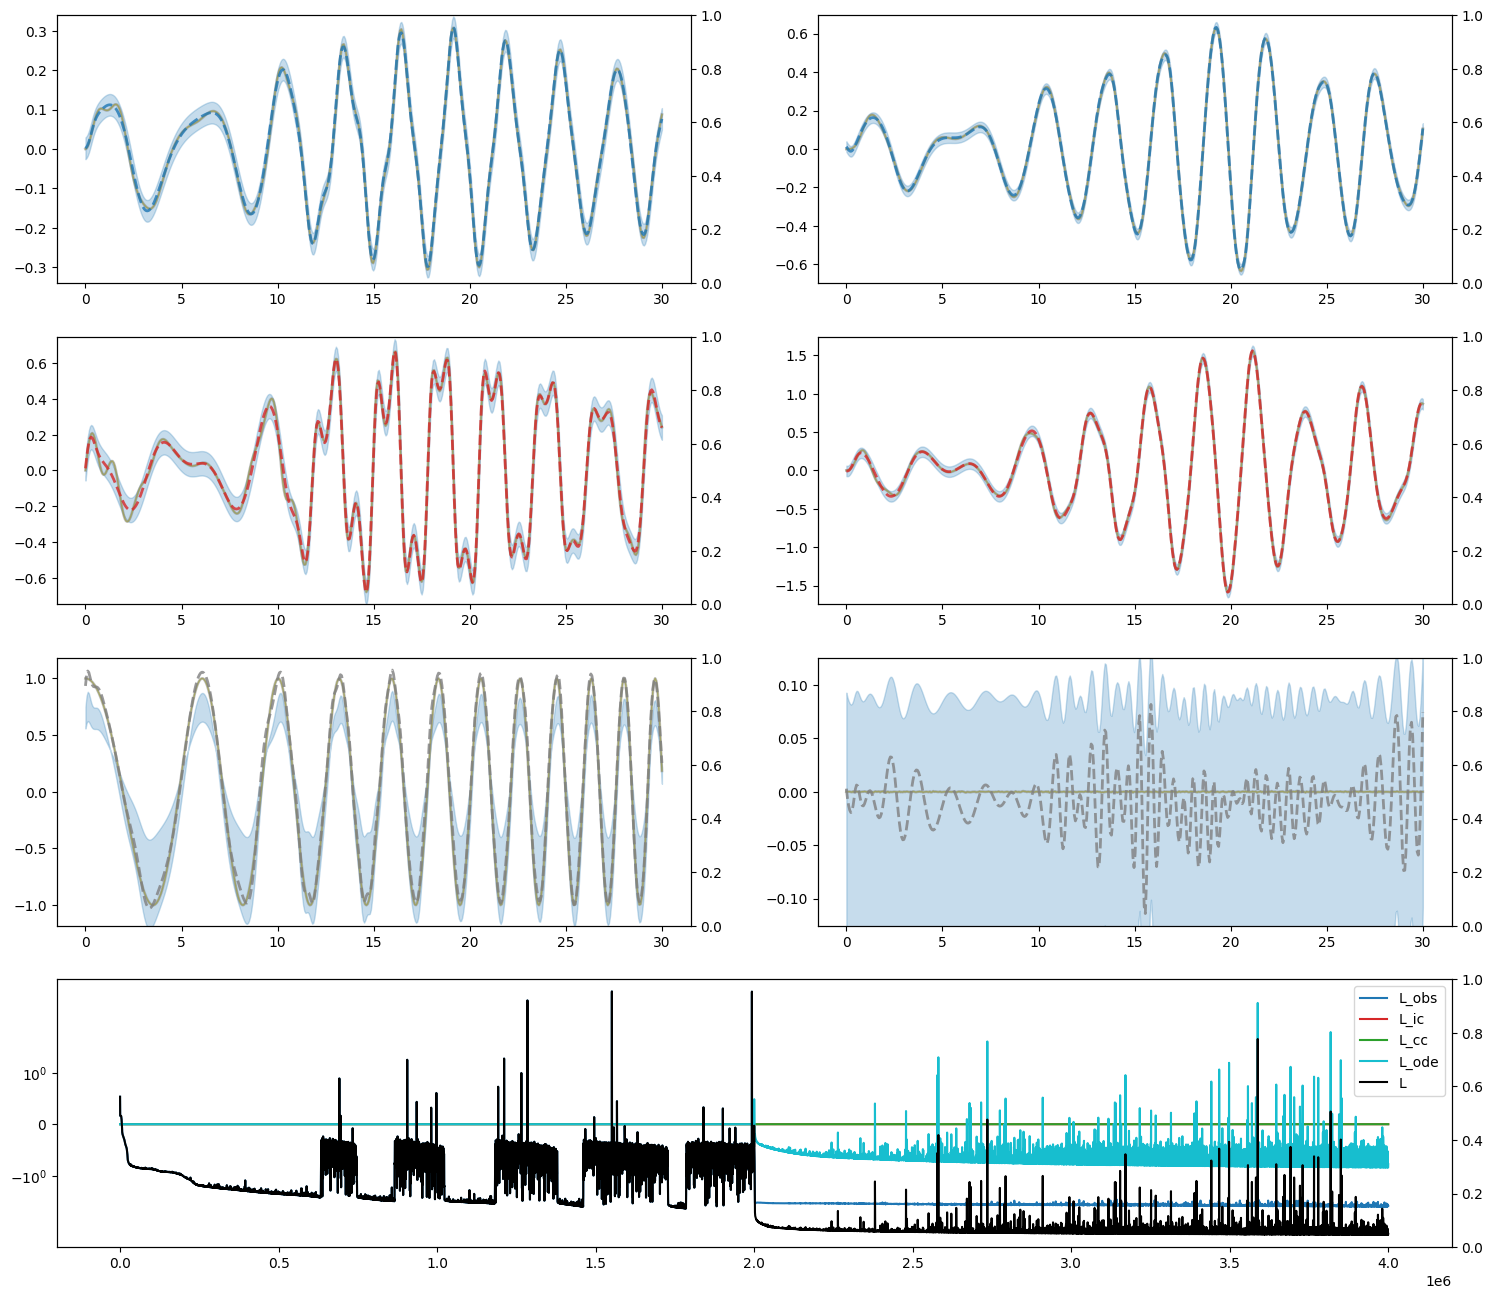

In [6]:
checkpoint = torch.load('checkpoints/mdof_stoch_instance.pth')
loss_hist = checkpoint["loss"]
mdof_model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# for name, param in mdof_model.named_parameters():
#     param.requires_grad = False

# mdof_model.c_.requires_grad = True
# mdof_model.k_.requires_grad = True
# mdof_model.kn_.requires_grad = True

clipper = ParamClipper()

for g in optimizer.param_groups:
    g['lr'] = 1e-3

fig, axs = plt.subplot_mosaic(
    mosaic_key,
    figsize=(18,16),
    facecolor='w'
)
axs2 = axs.copy()
for key, ax in axs.items():
    axs2[key] = ax.twinx()

print_step = 2000
lambds = {
    'obs' : 1.0e-3,
    'ic' : 0.0,
    'ode' : 1.0e-3,
    'cc' : 0.0
}

mdof_model.set_switches(lambds)

epochs = int(2e6)
for i in tqdm(range(epochs)):

    optimizer.zero_grad()
    loss, losses, residuals = mdof_model.loss_func(lambds)
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward()
    optimizer.step()
    mdof_model.apply(clipper)

    # mdof_model.apply(clipper)

    if (i+1) % print_step == 0:

        z_pred, f_pred = mdof_model.predict()

        prediction["x_hat"] = z_pred.detach()[:,:n_dof]
        prediction["v_hat"] = z_pred.detach()[:,n_dof:]
        prediction["F_hat"] = f_pred.detach()
        prediction['sigma'] = mdof_model.sigma_.detach()
        prediction['sigma_s'] = mdof_model.sigma_s_.detach()

        plot_result(axs, ground_truth, data, prediction, alphas)#, residuals['R_ode'], axs2)

        plot_joint_loss_hist(axs[alphabet[3*n_dof]], np.array(loss_hist))

        display.clear_output(wait=True)
        display.display(plt.gcf())
        tqdma.write("Epoch : %d ---- Loss: %.4e ---- sigma_o: %.4e ---- sigma_p: %.4e" % (i+1, loss_hist[i][-1], mdof_model.sigma_.detach(), mdof_model.sigma_s_.detach()))
        tqdma.write("c :                       k :                     kn : ")
        for j in range(n_dof):
            wri_str = '%d : ' % (j+1)
            for param in ['c_','k_','kn_']:
                if pinn_config['phys_params'][param]['type']=='constant':
                    wri_str += '%.4f ' % getattr(mdof_model,param)[j]
                elif pinn_config['phys_params'][param]['type']=='variable':
                    wri_str += '%.4f ' % (getattr(mdof_model,param)[j]*alphas[param[:-1]])
                wri_str += '[%.4f]       ' % true_params[param][j]
            tqdma.write(wri_str)

display.clear_output()
tqdma.write("Epoch : %d ---- Loss: %.4e ---- sigma_o: %.4e ---- sigma_p: %.4e" % (i+1, loss_hist[i][-1], mdof_model.sigma_.detach(), mdof_model.sigma_s_.detach()))
tqdma.write("c :                       k :                     kn : ")
for j in range(n_dof):
    wri_str = '%d : ' % (j+1)
    for param in ['c_','k_','kn_']:
        if pinn_config['phys_params'][param]['type']=='constant':
            wri_str += '%.4f ' % getattr(mdof_model,param)[j]
        elif pinn_config['phys_params'][param]['type']=='variable':
            wri_str += '%.4f ' % (getattr(mdof_model,param)[j]*alphas[param[:-1]])
        wri_str += '[%.4f]       ' % true_params[param][j]
    tqdma.write(wri_str)

In [ ]:
result_data = {
    'epoch' : i,
    # 'gt_config' : config,
    'osa_config' : pinn_config,
    'model' : pinn_config.state_dict(),
    'loss' : loss_hist,
    'ground_truth' : ground_truth,
    'data' : data,
    'prediction' : prediction,
    'alphas' : alphas
}

torch.save(result_data, 'results/osa_forced_mdof.pth')